In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Deep Learning/Proyecto1/data.csv")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118964 entries, 0 to 118963
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  118964 non-null  object
 1   spanish  118964 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [ ]:
dataset

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
118959,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118960,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118961,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118962,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


# LSTM

In [ ]:
# Importar librerías de procesamiento de texto y modelado
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu

# Parámetros globales
#LATENT_DIM = 256
#BATCH_SIZE = 64
#EPOCHS = 8
# Parámetros del modelo
LATENT_DIM = 256
input_vocab_size = 23849  # Tamaño del vocabulario en inglés
target_vocab_size = 41724  # Tamaño del vocabulario en español
BATCH_SIZE = 64
EPOCHS = 8

In [ ]:
# Verificar valores nulos
if dataset.isnull().sum().any():
    print("Advertencia: Existen valores nulos en el dataset.")
    dataset = dataset.dropna()
else:
    print("No se encontraron valores nulos.")

# Previsualizar datos
print("\nEjemplo de datos:")
print(dataset.head())

No se encontraron valores nulos.

Ejemplo de datos:
  english  spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.


In [ ]:
# Preparar los datos
input_texts = dataset['english'].values
target_texts = ['<start> ' + text + ' <end>' for text in dataset['spanish'].values]

# Tokenización para inglés
tokenizer_eng = Tokenizer(filters='')
tokenizer_eng.fit_on_texts(input_texts)
input_sequences = tokenizer_eng.texts_to_sequences(input_texts)
input_sequences = pad_sequences(input_sequences, padding='post')

# Tokenización para español
tokenizer_spa = Tokenizer(filters='')
tokenizer_spa.fit_on_texts(target_texts)
target_sequences = tokenizer_spa.texts_to_sequences(target_texts)
target_sequences = pad_sequences(target_sequences, padding='post')

# Vocabulario
input_vocab_size = len(tokenizer_eng.word_index) + 1
target_vocab_size = len(tokenizer_spa.word_index) + 1

print(f"Tamaño del vocabulario (inglés): {input_vocab_size}")
print(f"Tamaño del vocabulario (español): {target_vocab_size}")

# Dividir datos en entrenamiento y validación
input_train, input_val, target_train, target_val = train_test_split(
    input_sequences, target_sequences, test_size=0.2, random_state=42
)

Tamaño del vocabulario (inglés): 23849
Tamaño del vocabulario (español): 41724


In [ ]:
# Crear entradas y salidas para el decodificador
decoder_input_train = np.array([seq[:-1] for seq in target_train])
decoder_target_train = np.array([seq[1:] for seq in target_train])
decoder_input_val = np.array([seq[:-1] for seq in target_val])
decoder_target_val = np.array([seq[1:] for seq in target_val])

# Construcción del modelo

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_vocab_size, LATENT_DIM)(encoder_inputs)
encoder_lstm_outputs, state_h, state_c = LSTM(LATENT_DIM, return_state=True, return_sequences=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, LATENT_DIM)(decoder_inputs)
decoder_lstm_outputs, _, _ = LSTM(LATENT_DIM, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)

# Atención
attention = Attention()
context_vector = attention([decoder_lstm_outputs, encoder_lstm_outputs])

# Concatenación del contexto con la salida del decodificador
concat_layer = Concatenate(axis=-1)([context_vector, decoder_lstm_outputs])

# Capa densa para la predicción final
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat_layer)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      6,105,344 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │     10,681,344 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, None, 256),    │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, None, 256)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 512)      │              0 │ attention[0][0],       │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 41724)    │     21,404,412 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,241,724 (149.70 MB)

 Trainable params: 39,241,724 (149.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 505s 334ms/step - loss: 1.2298 - sparse_categorical_accuracy: 0.8759 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.9020
Epoch 2/8
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 511s 343ms/step - loss: 0.6011 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.4876 - val_sparse_categorical_accuracy: 0.9244
Epoch 3/8
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 563s 344ms/step - loss: 0.4018 - sparse_categorical_accuracy: 0.9304 - val_loss: 0.3996 - val_sparse_categorical_accuracy: 0.9370
Epoch 4/8
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 564s 346ms/step - loss: 0.2741 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.3619 - val_sparse_categorical_accuracy: 0.9425
Epoch 5/8
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 563s 347ms/step - loss: 0.1935 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.9452
Epoch 6/8
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 562s 347ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.3432 - val_sparse_cat

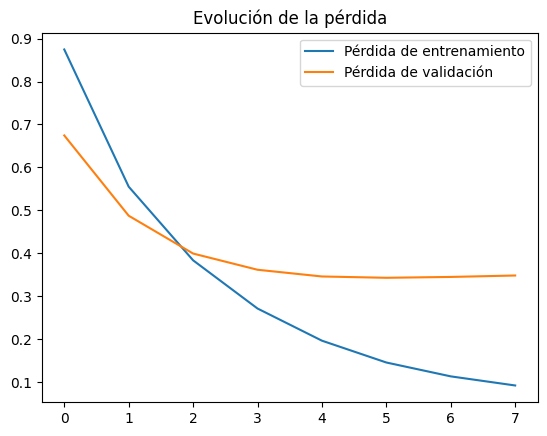

In [ ]:
# Entrenamiento
history = model.fit(
    [input_train, decoder_input_train],
    np.expand_dims(decoder_target_train, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        [input_val, decoder_input_val],
        np.expand_dims(decoder_target_val, -1)
    )
)

# Gráfica de la pérdida y la precisión
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Evolución de la pérdida')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Paso 1: Predecir etiquetas de clase
y_pred_probs = model_lstm.predict(X_test_pad)  # Obtiene probabilidades de cada clase
y_pred = np.argmax(y_pred_probs, axis=1)  # Convierte a etiquetas enteras

# Paso 2: Convertir y_test_one_hot a etiquetas enteras
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Paso 3: Generar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Paso 4: Graficar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_labels), yticklabels=np.unique(y_test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()

# Reporte de clasificación (precisión, recall, F1-score)
print(classification_report(y_test_labels, y_pred))


In [ ]:
# Guardar el modelo completo
model.save('/content/drive/MyDrive/Deep Learning/Proyecto1/translation_model2.h5')
print("Modelo guardado exitosamente en translation_model2.h5")


Modelo guardado exitosamente en translation_model2.h5


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/Deep Learning/Proyecto1/translation_model_lstm.h5')
print("Modelo cargado exitosamente.")
#model.summary()

Modelo cargado exitosamente.


In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Función para preprocesar el texto de entrada
def preprocess_input(text, tokenizer, max_length):
    # Convertir el texto en secuencias
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# Función para generar traducción con el modelo entrenado
def translate(model, input_text, input_tokenizer, target_tokenizer, max_input_length, max_target_length):
    # Preprocesar el texto de entrada
    input_seq = preprocess_input(input_text, input_tokenizer, max_input_length)

    # Inicializar la secuencia de entrada del decodificador
    decoder_input = np.zeros((1, max_target_length))  # Un batch de tamaño 1
    decoder_input[0, 0] = target_tokenizer.word_index['<start>']

    # Inicializar la salida
    translated_sentence = ""

    # Generar la traducción
    for t in range(1, max_target_length):
        # Hacer predicción
        output = model.predict([input_seq, decoder_input])

        # Obtener el índice de la palabra con la mayor probabilidad
        predicted_id = np.argmax(output[0, t-1, :])

        # Detener si se predice la palabra <end>
        if predicted_id == target_tokenizer.word_index['<end>']:
            break

        # Convertir el índice en una palabra
        predicted_word = target_tokenizer.index_word[predicted_id]
        translated_sentence += " " + predicted_word

        # Actualizar la entrada del decodificador
        decoder_input[0, t] = predicted_id

    # Eliminar espacios al inicio y al final
    return translated_sentence.strip()

# Ejemplo de uso para traducir una lista de oraciones

# Ingresar una lista de oraciones en inglés
input_texts = [
    "what is your name",
    "how are you",
    "where do you live",
    "what time is it",
    "thank you very much"
]

# Traducir cada oración de la lista
for input_text in input_texts:
    translated_text = translate(model, input_text, tokenizer_eng, tokenizer_spa,
                                max_input_length=input_train.shape[1], max_target_length=target_train.shape[1])

    print(f"Texto en inglés: {input_text}")
    print(f"Traducción al español: {translated_text}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Texto en inglés: what is your name
Traducción al español: ¿qué es tu nombre.
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Texto en inglés: how are you
Traducción al español: ¿cómo te sientes?
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Texto en inglés: where do you live
Traducción al español: ¿dónde vive usted el sitio?
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [ ]:
pip install gradio

In [ ]:
import numpy as np
import pandas as pd
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention

# Cargar el modelo guardado
#model = load_model('/content/drive/MyDrive/Deep Learning/Proyecto1/translation_model2.h5', custom_objects={'Attention': Attention})
#print("Modelo cargado exitosamente.")

# Cargar el dataset para obtener las frases (asegúrate de cargarlo correctamente desde tu archivo)
#dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/Proyecto1/data.csv')

# Tokenización para inglés
input_texts = dataset['english'].values
tokenizer_eng = Tokenizer(filters='')
tokenizer_eng.fit_on_texts(input_texts)

# Tokenización para español
target_texts = ['<start> ' + text + ' <end>' for text in dataset['spanish'].values]
tokenizer_spa = Tokenizer(filters='')
tokenizer_spa.fit_on_texts(target_texts)

# Preprocesamiento de entrada para el modelo
def preprocess_input(text, tokenizer, max_length):
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# Función para la traducción
def translate(input_text):
    # Preprocesar el texto de entrada
    input_sequence = preprocess_input(input_text, tokenizer_eng, max_length=10)  # Ajusta max_length según el modelo

    # Crear el input para el decoder (usamos <start> para el inicio)
    decoder_input = np.array([[tokenizer_spa.word_index['<start>']]])

    # Lista para almacenar las palabras generadas
    translated_words = []

    for _ in range(10):  # Limita la cantidad de palabras generadas
        output_tokens = model.predict([input_sequence, decoder_input])

        # Obtener la palabra más probable
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_spa.index_word.get(sampled_token_index, '')

        # Si el modelo predice <end>, detenemos la generación
        if sampled_word == '<end>' or sampled_word in translated_words:
            break

        translated_words.append(sampled_word)

        # Actualizar el input del decoder
        decoder_input = np.array([[sampled_token_index]])

    return " ".join(translated_words).strip()

# Crear la interfaz de usuario con Gradio
iface = gr.Interface(fn=translate, inputs="text", outputs="text", title="Traducción de Inglés a Español",
                     description="Introduce una frase en inglés y obtén la traducción al español.")

# Lanzar la interfaz de usuario
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f9cb3b355e859b3dd6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, Reshape, MultiHeadAttention, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Deep Learning/Proyecto1/data.csv")

In [ ]:
# Parámetros globales
LATENT_DIM = 256
input_vocab_size = 23849  # Tamaño del vocabulario en inglés
target_vocab_size = 41724  # Tamaño del vocabulario en español
BATCH_SIZE = 64
EPOCHS = 5

# Verificar valores nulos
if dataset.isnull().sum().any():
    print("Advertencia: Existen valores nulos en el dataset.")
    dataset = dataset.dropna()
else:
    print("No se encontraron valores nulos.")

# Previsualizar datos
print("\nEjemplo de datos:")
print(dataset.head())


No se encontraron valores nulos.

Ejemplo de datos:
  english  spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.


In [ ]:

# Preparar los datos
input_texts = dataset['english'].values
target_texts = ['<start> ' + text + ' <end>' for text in dataset['spanish'].values]

# Tokenización para inglés
tokenizer_eng = Tokenizer(filters='')
tokenizer_eng.fit_on_texts(input_texts)
input_sequences = tokenizer_eng.texts_to_sequences(input_texts)
input_sequences = pad_sequences(input_sequences, padding='post')

# Tokenización para español
tokenizer_spa = Tokenizer(filters='')
tokenizer_spa.fit_on_texts(target_texts)
target_sequences = tokenizer_spa.texts_to_sequences(target_texts)
target_sequences = pad_sequences(target_sequences, padding='post')

# Vocabulario
input_vocab_size = len(tokenizer_eng.word_index) + 1
target_vocab_size = len(tokenizer_spa.word_index) + 1

print(f"Tamaño del vocabulario (inglés): {input_vocab_size}")
print(f"Tamaño del vocabulario (español): {target_vocab_size}")

Tamaño del vocabulario (inglés): 23849
Tamaño del vocabulario (español): 41724


In [ ]:
# Dividir datos en entrenamiento y validación
input_train, input_val, target_train, target_val = train_test_split(
    input_sequences, target_sequences, test_size=0.2, random_state=42
)

# Crear entradas y salidas para el decodificador
decoder_input_train = np.array([seq[:-1] for seq in target_train])
decoder_target_train = np.array([seq[1:] for seq in target_train])
decoder_input_val = np.array([seq[:-1] for seq in target_val])
decoder_target_val = np.array([seq[1:] for seq in target_val])

# Construcción del modelo Transformer

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_vocab_size, LATENT_DIM)(encoder_inputs)
encoder_attention = MultiHeadAttention(num_heads=8, key_dim=LATENT_DIM)(encoder_embedding, encoder_embedding)
encoder_attention = LayerNormalization()(encoder_attention)
encoder_attention = Dropout(0.1)(encoder_attention)

# Reshape para asegurar las 3 dimensiones necesarias
encoder_output = Reshape((-1, LATENT_DIM))(encoder_attention)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, LATENT_DIM)(decoder_inputs)

# Asegurarse de que las entradas al decoder también tengan 3 dimensiones
decoder_attention = MultiHeadAttention(num_heads=8, key_dim=LATENT_DIM)(decoder_embedding, encoder_output)
decoder_attention = LayerNormalization()(decoder_attention)
decoder_attention = Dropout(0.1)(decoder_attention)

# Salida del decoder con TimeDistributed para secuencias
decoder_output = TimeDistributed(Dense(target_vocab_size, activation='softmax'))(decoder_attention)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 256)      │      6,105,344 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 256)      │      2,103,552 │ embedding_2[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, None, 256)      │            512 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 256)      │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │     10,681,344 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, None, 256)      │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, None, 256)      │      2,103,552 │ embedding_3[0][0],     │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, None, 256)      │            512 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 256)      │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 41724)    │     10,723,068 │ dropout_3[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,717,884 (120.99 MB)

 Trainable params: 31,717,884 (120.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento
history = model.fit(
    [input_train, decoder_input_train],
    np.expand_dims(decoder_target_train, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        [input_val, decoder_input_val],
        np.expand_dims(decoder_target_val, -1)
    )
)


Epoch 1/5


KeyboardInterrupt: 

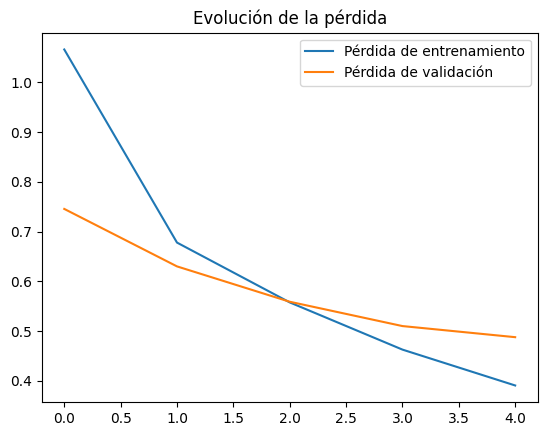

In [ ]:

# Gráfica de la pérdida y la precisión
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Evolución de la pérdida')
plt.show()

In [ ]:
# Guardar el modelo completo en un archivo .h5
model.save('/content/drive/MyDrive/Deep Learning/Proyecto1/modelo_transformer.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/Deep Learning/Proyecto1/modelo_transformer.h5')
print("Modelo cargado exitosamente.")
#model.summary()

Modelo cargado exitosamente.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

# Función para preprocesar el texto de entrada
def preprocess_input(text, tokenizer, max_length):
    # Convertir el texto en secuencias
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# Función para generar traducción con el modelo entrenado
def translate(model, input_text, input_tokenizer, target_tokenizer, max_input_length, max_target_length):
    # Preprocesar el texto de entrada
    input_seq = preprocess_input(input_text, input_tokenizer, max_input_length)

    # Inicializar la secuencia de entrada del decodificador
    decoder_input = np.zeros((1, max_target_length))  # Un batch de tamaño 1
    decoder_input[0, 0] = target_tokenizer.word_index['<start>']

    # Inicializar la salida
    translated_sentence = ""

    # Generar la traducción
    for t in range(1, max_target_length):
        # Hacer predicción
        output = model.predict([input_seq, decoder_input])

        # Obtener el índice de la palabra con la mayor probabilidad (Top-1)
        predicted_id = np.argmax(output[0, t-1, :])

        # Detener si se predice la palabra <end>
        if predicted_id == target_tokenizer.word_index['<end>']:
            break

        # Convertir el índice en una palabra
        predicted_word = target_tokenizer.index_word[predicted_id]
        translated_sentence += " " + predicted_word

        # Actualizar la entrada del decodificador
        decoder_input[0, t] = predicted_id

    return translated_sentence.strip()

# Función para evaluar la traducción utilizando BLEU score
def evaluate_translation(reference, candidate):
    # Convertir las oraciones en listas de palabras
    reference = [reference.split()]
    candidate = candidate.split()

    # Calcular el BLEU score
    bleu_score = sentence_bleu(reference, candidate)
    return bleu_score

# Ejemplo de uso para realizar una prueba
input_texts = [
    "what is your name",
    "how are you",
    "where do you live",
    "what time is it",
    "thank you very much"
]  # Lista de oraciones en inglés

# Definir las traducciones de referencia en español (esto es solo un ejemplo)
reference_texts = [
    "¿Cuál es tu nombre?",
    "¿Cómo estás?",
    "¿Dónde vives?",
    "¿Qué hora es?",
    "Muchas gracias"
]  # Las traducciones correctas en español

# Realizar la traducción y evaluación para cada oración en input_texts
for i, input_text in enumerate(input_texts):
    # Realizar la traducción con el modelo (asegúrate de que el modelo y los tokenizadores estén definidos)
    translated_text = translate(model, input_text, tokenizer_eng, tokenizer_spa,
                                max_input_length=input_train.shape[1], max_target_length=target_train.shape[1])

    # Imprimir resultados
    print(f"Texto en inglés: {input_text}")
    print(f"Traducción al español: {translated_text}")

    # Evaluación de la traducción utilizando BLEU score
    reference_text = reference_texts[i]  # Referencia correspondiente para esta oración
    bleu_score = evaluate_translation(reference_text, translated_text)
    print(f"BLEU score: {bleu_score:.4f}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Texto en inglés: how are you
Traducción al español: ¿cuántos estás en mí?
BLEU score: 0.0000
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/ste

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Texto en inglés: thank you very much
Traducción al español: gracias por mucho afortunados.
BLEU score: 0.0000
--------------------------------------------------


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

# Función para preprocesar el texto de entrada
def preprocess_input(text, tokenizer, max_length):
    # Convertir el texto en secuencias
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# Función para generar traducción con el modelo entrenado
def translate(model, input_text, input_tokenizer, target_tokenizer, max_input_length, max_target_length):
    # Preprocesar el texto de entrada
    input_seq = preprocess_input(input_text, input_tokenizer, max_input_length)

    # Inicializar la secuencia de entrada del decodificador
    decoder_input = np.zeros((1, max_target_length))  # Un batch de tamaño 1
    decoder_input[0, 0] = target_tokenizer.word_index['<start>']

    # Inicializar la salida
    translated_sentence = ""

    # Generar la traducción
    for t in range(1, max_target_length):
        # Hacer predicción
        output = model.predict([input_seq, decoder_input])

        # Obtener el índice de la palabra con la mayor probabilidad (Top-1)
        predicted_id = np.argmax(output[0, t-1, :])

        # Detener si se predice la palabra <end>
        if predicted_id == target_tokenizer.word_index['<end>']:
            break

        # Convertir el índice en una palabra
        predicted_word = target_tokenizer.index_word[predicted_id]
        translated_sentence += " " + predicted_word

        # Actualizar la entrada del decodificador
        decoder_input[0, t] = predicted_id

    return translated_sentence.strip()

# Función para evaluar la traducción utilizando BLEU score
def evaluate_translation(reference, candidate):
    # Convertir las oraciones en listas de palabras
    reference = [reference.split()]
    candidate = candidate.split()

    # Calcular el BLEU score
    bleu_score = sentence_bleu(reference, candidate)
    return bleu_score

# Ejemplo de uso para realizar una prueba
input_texts = [
    "what is your name"
]  # Ingresar una oración en inglés

# Realizar la traducción con el modelo (asegúrate de que el modelo y los tokenizadores estén definidos)
# El modelo debe ser entrenado previamente, y `input_train`, `target_train` deben ser definidos.
translated_text = translate(model, input_text, tokenizer_eng, tokenizer_spa,
                            max_input_length=input_train.shape[1], max_target_length=target_train.shape[1])

# Imprimir resultados
print(f"Texto en inglés: {input_text}")
print(f"Traducción al español: {translated_text}")

# Evaluación de la traducción utilizando BLEU score
reference_text = "hola"  # La traducción correcta de "hello" (en español)
bleu_score = evaluate_translation(reference_text, translated_text)
print(f"BLEU score: {bleu_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
pip install gradio

In [ ]:
import numpy as np
import pandas as pd
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/Deep Learning/Proyecto1/modelo_transformer.h5', custom_objects={'Attention': Attention})
print("Modelo cargado exitosamente.")

# Cargar el dataset para obtener las frases (asegúrate de cargarlo correctamente desde tu archivo)
dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/Proyecto1/data.csv')

# Tokenización para inglés
input_texts = dataset['english'].values
tokenizer_eng = Tokenizer(filters='')
tokenizer_eng.fit_on_texts(input_texts)

# Tokenización para español
target_texts = ['<start> ' + text + ' <end>' for text in dataset['spanish'].values]
tokenizer_spa = Tokenizer(filters='')
tokenizer_spa.fit_on_texts(target_texts)

# Preprocesamiento de entrada para el modelo
def preprocess_input(text, tokenizer, max_length):
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

def translate(input_text, max_length=10, max_repeats=1):
    # Preprocesar el texto de entrada
    input_sequence = preprocess_input(input_text, tokenizer_eng, max_length)

    # Crear el input para el decoder (usamos <start> para el inicio)
    decoder_input = np.array([[tokenizer_spa.word_index['<start>']]])

    # Predicción paso a paso
    translated_sentence = ''
    word_count = {}  # Diccionario para contar repeticiones de palabras

    for _ in range(max_length):
        # Predecir la siguiente palabra
        output_tokens = model.predict([input_sequence, decoder_input], verbose=0)

        # Obtener la palabra más probable
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_spa.index_word.get(sampled_token_index, '')

        # Si se encuentra la palabra <end>, detener la generación
        if sampled_word == '<end>':
            break

        # Evitar que una palabra se repita más de `max_repeats` veces
        if sampled_word in word_count:
            if word_count[sampled_word] >= max_repeats:
                continue  # Saltar esta palabra si ya se ha repetido demasiado
            word_count[sampled_word] += 1
        else:
            word_count[sampled_word] = 1

        # Añadir la palabra al resultado
        translated_sentence += ' ' + sampled_word

        # Actualizar el input del decoder
        decoder_input = np.hstack([decoder_input, np.array([[sampled_token_index]])])

    return translated_sentence.strip()

# Crear la interfaz de usuario con Gradio
iface = gr.Interface(
    fn=translate,
    inputs="text",
    outputs="text",
    title="Traducción de Inglés a Español",
    description="Introduce una frase en inglés y obtén la traducción al español."
)

# Lanzar la interfaz de usuario
iface.launch()


Modelo cargado exitosamente.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5206058562704ce411.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# TRANSFORMER 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, Reshape, MultiHeadAttention, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Cargar datos
dataset = pd.read_csv("/content/drive/MyDrive/Deep learning01/data.csv")

# Verificar valores nulos
if dataset.isnull().sum().any():
    print("Advertencia: Existen valores nulos en el dataset.")
    dataset = dataset.dropna()
else:
    print("No se encontraron valores nulos.")

# Previsualizar datos
print("\nEjemplo de datos:")
print(dataset.head())

# Preparar los datos
input_texts = dataset['english'].values
target_texts = ['<start> ' + text + ' <end>' for text in dataset['spanish'].values]

# Tokenización para inglés
tokenizer_eng = Tokenizer(filters='')
tokenizer_eng.fit_on_texts(input_texts)
input_sequences = tokenizer_eng.texts_to_sequences(input_texts)
input_sequences = pad_sequences(input_sequences, padding='post')

# Tokenización para español
tokenizer_spa = Tokenizer(filters='')
tokenizer_spa.fit_on_texts(target_texts)
target_sequences = tokenizer_spa.texts_to_sequences(target_texts)
target_sequences = pad_sequences(target_sequences, padding='post')

# Vocabulario
input_vocab_size = len(tokenizer_eng.word_index) + 1
target_vocab_size = len(tokenizer_spa.word_index) + 1

print(f"Tamaño del vocabulario (inglés): {input_vocab_size}")
print(f"Tamaño del vocabulario (español): {target_vocab_size}")

# Dividir datos en entrenamiento y validación
input_train, input_val, target_train, target_val = train_test_split(
    input_sequences, target_sequences, test_size=0.2, random_state=42
)

# Crear entradas y salidas para el decodificador
decoder_input_train = np.array([seq[:-1] for seq in target_train])
decoder_target_train = np.array([seq[1:] for seq in target_train])
decoder_input_val = np.array([seq[:-1] for seq in target_val])
decoder_target_val = np.array([seq[1:] for seq in target_val])

# Construcción del modelo Transformer

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_attention = MultiHeadAttention(num_heads=8, key_dim=256)(encoder_embedding, encoder_embedding)
encoder_attention = LayerNormalization()(encoder_attention)
encoder_attention = Dropout(0.1)(encoder_attention)
encoder_output = Reshape((-1, 256))(encoder_attention)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(target_vocab_size, 256)(decoder_inputs)
decoder_attention = MultiHeadAttention(num_heads=8, key_dim=256)(decoder_embedding, encoder_output)
decoder_attention = LayerNormalization()(decoder_attention)
decoder_attention = Dropout(0.1)(decoder_attention)
decoder_output = TimeDistributed(Dense(target_vocab_size, activation='softmax'))(decoder_attention)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
callbacks = [checkpoint, early_stopping, reduce_lr]

# Entrenamiento
history = model.fit(
    [input_train, decoder_input_train], decoder_target_train,
    validation_data=([input_val, decoder_input_val], decoder_target_val),
    batch_size=64, epochs=12, callbacks=callbacks
)

No se encontraron valores nulos.

Ejemplo de datos:
  english  spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.
Tamaño del vocabulario (inglés): 23849
Tamaño del vocabulario (español): 41724


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      6,105,344 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 256)      │      2,103,552 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, None, 256)      │            512 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 256)      │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │     10,681,344 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, None, 256)      │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, None, 256)      │      2,103,552 │ embedding_1[0][0],     │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, None, 256)      │            512 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 256)      │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 41724)    │     10,723,068 │ dropout_3[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,717,884 (120.99 MB)

 Trainable params: 31,717,884 (120.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 1.6235 - sparse_categorical_accuracy: 0.8596

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 395s 251ms/step - loss: 1.6231 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.7696 - val_sparse_categorical_accuracy: 0.8929 - learning_rate: 0.0010
Epoch 2/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.7313 - sparse_categorical_accuracy: 0.8959

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 410s 239ms/step - loss: 0.7313 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.9030 - learning_rate: 0.0010
Epoch 3/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.5957 - sparse_categorical_accuracy: 0.9091

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 382s 240ms/step - loss: 0.5957 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.5892 - val_sparse_categorical_accuracy: 0.9109 - learning_rate: 0.0010
Epoch 4/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.4885 - sparse_categorical_accuracy: 0.9193

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 384s 241ms/step - loss: 0.4885 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.5385 - val_sparse_categorical_accuracy: 0.9166 - learning_rate: 0.0010
Epoch 5/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.9262

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 385s 244ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.5074 - val_sparse_categorical_accuracy: 0.9205 - learning_rate: 0.0010
Epoch 6/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.3503 - sparse_categorical_accuracy: 0.9324

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 381s 243ms/step - loss: 0.3503 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.4868 - val_sparse_categorical_accuracy: 0.9236 - learning_rate: 0.0010
Epoch 7/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.9383

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 381s 242ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.4797 - val_sparse_categorical_accuracy: 0.9258 - learning_rate: 0.0010
Epoch 8/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.2638 - sparse_categorical_accuracy: 0.9438

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 362s 229ms/step - loss: 0.2638 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.4706 - val_sparse_categorical_accuracy: 0.9270 - learning_rate: 0.0010
Epoch 9/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9483

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 379s 227ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.4658 - val_sparse_categorical_accuracy: 0.9286 - learning_rate: 0.0010
Epoch 10/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9519

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 355s 238ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.9293 - learning_rate: 0.0010
Epoch 11/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 348s 234ms/step - loss: 0.1967 - sparse_categorical_accuracy: 0.9552 - val_loss: 0.4656 - val_sparse_categorical_accuracy: 0.9302 - learning_rate: 0.0010
Epoch 12/12
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 362s 221ms/step - loss: 0.1840 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.4670 - val_sparse_categorical_accuracy: 0.9310 - learning_rate: 0.0010


In [3]:
# Guardar el modelo completo
model.save('/content/drive/MyDrive/Deep learning01/best_model_transformer.h5')

print("Modelo guardado exitosamente en Google Drive.")


Modelo guardado exitosamente en Google Drive.


In [4]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model_loaded = load_model('/content/drive/MyDrive/Deep learning01/best_model_transformer.h5')

# Verificar la estructura del modelo cargado
model_loaded.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      6,105,344 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 256)      │      2,103,552 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, None, 256)      │            512 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 256)      │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │     10,681,344 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, None, 256)      │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, None, 256)      │      2,103,552 │ embedding_1[0][0],     │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, None, 256)      │            512 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 256)      │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 41724)    │     10,723,068 │ dropout_3[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,717,886 (120.99 MB)

 Trainable params: 31,717,884 (120.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

def preprocess_input(text, tokenizer, max_length):
    """Convierte el texto en una secuencia de enteros y la paddea."""
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# Modificación de la función translate()
def translate(model, input_text, input_tokenizer, target_tokenizer, max_input_length, max_target_length):
    input_seq = preprocess_input(input_text, input_tokenizer, max_input_length)
    decoder_input = np.zeros((1, max_target_length))
    decoder_input[0, 0] = target_tokenizer.word_index['<start>']

    translated_sentence = []
    seen_words = set()  # Para evitar repeticiones

    for t in range(1, max_target_length):
        output = model.predict([input_seq, decoder_input])
        predicted_id = np.argmax(output[0, t-1, :])

        # Detener si predice '<end>' o si la palabra ya se repitió muchas veces
        if predicted_id == target_tokenizer.word_index['<end>'] or predicted_id in seen_words:
            break

        predicted_word = target_tokenizer.index_word.get(predicted_id, "")
        translated_sentence.append(predicted_word)
        seen_words.add(predicted_id)  # Agregar palabra al conjunto de palabras vistas

        # Actualizar la entrada del decodificador
        decoder_input[0, t] = predicted_id

    return " ".join(translated_sentence)

def evaluate_translation(reference, candidate):
    """Calcula el BLEU score para evaluar la calidad de la traducción."""
    reference = [reference.split()]
    candidate = candidate.split()
    return sentence_bleu(reference, candidate)

# Prueba con un ejemplo
test_sentence = "what is your name"
translated_text = translate(model, test_sentence, tokenizer_eng, tokenizer_spa,
                            max_input_length=input_train.shape[1], max_target_length=target_train.shape[1])

print(f"Texto en inglés: {test_sentence}")
print(f"Traducción al español: {translated_text}")

reference_text = "¿cuál es tu nombre?"
bleu_score = evaluate_translation(reference_text, translated_text)
print(f"BLEU score: {bleu_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Texto en inglés: what is your name
Traducción al español: ¿cuál es tu nombre
BLEU score: 8.636168555094496e-78


In [9]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [13]:
import numpy as np
import pandas as pd
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention



# Longitudes máximas
MAX_INPUT_LENGTH = 20
MAX_TARGET_LENGTH = 20

# Función para preprocesar la entrada
def preprocess_input(text, tokenizer, max_length):
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# Función corregida para traducción
def translate(input_text, max_length=MAX_TARGET_LENGTH, max_repeats=1):
    input_sequence = preprocess_input(input_text, tokenizer_eng, MAX_INPUT_LENGTH)
    decoder_input = np.array([[tokenizer_spa.word_index['<start>']]])

    translated_sentence = []
    word_count = {}

    for _ in range(max_length):
        output_tokens = model.predict([input_sequence, decoder_input], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Obtener la palabra y manejar errores
        sampled_word = tokenizer_spa.index_word.get(sampled_token_index, '')
        if not sampled_word or sampled_word == '<end>':
            break

        # Evitar repeticiones
        word_count[sampled_word] = word_count.get(sampled_word, 0) + 1
        if word_count[sampled_word] > max_repeats:
            continue

        translated_sentence.append(sampled_word)
        decoder_input = np.hstack([decoder_input, np.array([[sampled_token_index]])])

        # 🔴 **Prevención de bucles infinitos**: Romper si el input del decoder se hace demasiado largo
        if decoder_input.shape[1] >= max_length:
            break

    return " ".join(translated_sentence) if translated_sentence else "⚠ No se pudo generar la traducción."

# Crear interfaz Gradio
iface = gr.Interface(
    fn=translate,
    inputs=gr.Textbox(lines=2, placeholder="Escribe en inglés..."),
    outputs=gr.Textbox(label="Traducción al Español"),
    title="🌍 Traductor IA Inglés ➝ Español",
    description="Escribe una oración en inglés y obtén su traducción en español.",
    theme="default"
)

# Ejecutar interfaz
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4a56c54f4c6692c3dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
